# Producer/Consumer Ratio of DNS

## Preamble
Within an enterprise network, all network nodes are producer and consumers of data in someway or another.  At an atomic level, a network node will have a typical "behaviour profile" related to its consumption/production known as the Producer/Consumer Ratio (PCR).  Mathematically, PCR can be expressed as:


$$ PCR = \frac{SrcAppBytes - DstAppBytes}{SrcAppBytes + DstAppBytes} $$

and expresses whether a device can be classified as more of a producer or a consumer.  A network node that achieves a PCR of 1.0 tends to be purely pushing data or conversely a PCR of -1.0 represents behaviours related to consuming.

Although PCR can be applied to to all network connections from a node, it is often better to perform analysis on particular protocols inorder to isolate the signal to noise ratio further.  One popular target protocol is DNS due to its preveleance as a exfiltration technique and smaller domain of behaviours (when compared to something wild like HTTP).  

## Required Data:
Primary data required for this technique are connection logs which may come in various forms such as NetFlow, Bro Logs, Argus, etc.

## Hunt
***Hunt Hypothesis: ***  Groups of users within the same business unit will generate similar DNS traffic.  Applying the Producer Consumer Ratio to each of these hosts should reveal similar values.

 
<hr>
# Scenario

You have collected the Bro conn.logs from the Accounting VLAN for PCR Analysis.

### Data Schema
| Field          | Desc                                                 | Type     | 
|----------------|------------------------------------------------------|----------|
| ts             | Timestamp of connection                              | datetime |
| uid            | Unique ID of connection                              | string   |
| id.orig_h      | Originating connection's host IP address             | string   |
| id.orig_p      | Originating connection's host port number            | integer  |
| id.resp_h      | Responding connection's host IP address              | string   |
| id.resp_p      | Responding connection's host port number             | integer  |
| proto          | Transport layer protocol of connection               | string   |
| service        | Dynamically detected application protocol, if any    | string   |
| duration       | Length of time of the connection                     | float    |
| orig_bytes     | Originators payload bytes                            | integer  |
| resp_bytes     | Responder payload bytes                              | integer  |
| conn_state     | Connection state                                     | string   |
| local_orig     | If conn originated locally; T, if remotely F         | boolean  |
| missed_bytes   | Number of missi9ng bytes in content gaps             | integer  |
| history        | Connection state history                             | string   |
| orig_pkts      | Number of orig packets                               | integer  |
| orig_ip_bytes  | Number of Orig IP bytes                              | integer  |
| resp_pkts      | Number of responding packets                         | integer  |
| resp_ip_bytes  | Number of Resp IP bytes                              | integer  |
| tunnel_parents | If tunneled, connection UID of encapsulating parents | string   |



In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Ingestion

Given that the Bro conn.logs reside in a flat file structure, and with there only exist approximately 2,000 logs we will write two functions to convert all files within the "./dataset/a/*/conn.log" into one Pandas DataFrame.  Should this data exist within a Database or Hadoop DataLake, a connector or PySpark may be useful.

In [81]:
def parseBro(file):
    """This function converts a given conn.log into a Pandas DataFrame. 
    """
    
    df = pd.read_csv(file, delimiter='\t', skiprows=[0,1,2,3,4,5,6], skipfooter=1, engine='python')
     
    df.columns = ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','proto','service','duration','orig_bytes','resp_bytes','conn_state',
                  'local_orig','missed_bytes','history','orig_pkts','orig_ip_bytes','resp_pkts','resp_ip_bytes','tunnel_parents', 'delete']
    
    # Typecast the 'ts' column to be a Python datetime
    df['ts'] = pd.to_datetime(df['ts'],unit='s')
    
    return df

def generateDF(files):
    """Generates a single DataFrame from a collection of conn.logs
    """
    
    # Initialise an empty DataFrame
    df = pd.DataFrame()
    
    for file in files:
        df = pd.concat([df, parseBro('./dataset/a/' + str(file) + '/conn.log')])
        
    return df

directoryList = os.listdir(path='./dataset/a/')[1:200]
df = generateDF(directoryList)

display(df.head())

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,delete
0,2011-10-20 18:50:37.091036797,CIK4hf3Pjcg9cT7sGf,192.168.57.10,1032,91.202.63.125,80,tcp,-,-,-,...,SHR,-,0,f,0,0,1,40,(empty),NaN
1,2011-10-20 18:50:38.901093006,CQa8b82KZ6GRlT0gt8,192.168.57.10,1033,91.202.63.125,80,tcp,-,-,-,...,SHR,-,0,f,0,0,1,40,(empty),NaN
2,2011-10-20 18:50:53.388648033,CYsOGG3qz0kavYxQJh,192.168.57.10,1032,91.202.63.125,80,tcp,-,0.000188,0,...,RSTO,-,0,fR,1,40,1,40,(empty),NaN
3,2011-10-20 18:50:50.285473108,CtB9cW2SKzKHbO3Ene,192.168.57.10,1029,4.2.2.3,53,udp,dns,1.250414,79,...,SF,-,0,Dd,2,135,1,86,(empty),NaN
4,2011-10-20 18:50:56.606280088,CE0IMq39a6QkwLrZbg,192.168.57.10,1033,91.202.63.125,80,tcp,-,0.000209,0,...,RSTO,-,0,fR,1,40,1,40,(empty),NaN


## Explore Data Scope

As a preventitative measure - let's check that the database is correctly made. 

In [82]:
display(df['id.orig_h'].unique())

df = df[df['id.orig_h'].str.contains('192.168.', regex=False)]
display(df['id.orig_h'].unique())

display(df['service'].unique())
df = df[df['id.resp_p'] == 53]
display(df['service'].unique())

display(df.head())

array(['192.168.57.10', '0.0.0.0', '192.168.36.10', '192.168.41.10',
       '190.98.23.165', '187.204.44.233', '87.198.81.57', '111.174.0.230',
       '192.168.124.10', '192.168.27.10', '192.168.61.10',
       '151.34.24.249', '66.150.55.188', '192.168.5.10', '213.205.18.146',
       '88.253.254.255', '192.168.30.10', '192.168.77.10',
       '217.150.54.57', '117.231.10.25', '190.56.108.107', '86.61.194.37',
       '105.133.83.62', '192.168.86.10', '192.168.73.10', '192.168.17.10',
       '78.39.236.3', '68.85.98.230', '200.216.183.75', '192.168.37.10',
       '192.168.2.10', '192.168.32.10', '31.172.138.57', '176.33.255.255',
       '192.168.58.10', '192.168.82.10', '192.168.28.10',
       '192.168.123.10', '68.85.147.30', '78.39.236.1', '68.85.216.2',
       '192.168.96.10', '192.168.19.10', '192.168.104.10',
       '192.168.16.10', '80.80.209.38', '87.219.129.73', '192.34.253.132',
       '209.127.98.150', '69.243.108.237', '192.168.26.10',
       '192.168.38.10', '192.168.35.10', '

array(['192.168.57.10', '192.168.36.10', '192.168.41.10',
       '192.168.124.10', '192.168.27.10', '192.168.61.10', '192.168.5.10',
       '192.168.30.10', '192.168.77.10', '192.168.86.10', '192.168.73.10',
       '192.168.17.10', '192.168.37.10', '192.168.2.10', '192.168.32.10',
       '192.168.58.10', '192.168.82.10', '192.168.28.10',
       '192.168.123.10', '192.168.96.10', '192.168.19.10',
       '192.168.104.10', '192.168.16.10', '192.168.26.10',
       '192.168.38.10', '192.168.35.10', '192.168.103.10',
       '192.168.94.10', '192.168.44.10', '192.168.68.10',
       '192.168.111.10', '192.168.18.10', '192.168.98.10',
       '192.168.31.10', '192.168.50.10', '192.168.53.10',
       '192.168.119.10', '192.168.122.10', '192.168.69.10',
       '192.168.39.10', '192.168.33.10', '192.168.100.10',
       '192.168.118.10', '192.168.106.10', '192.168.101.10',
       '192.168.25.10', '192.168.8.10', '192.168.110.10', '192.168.21.10',
       '192.168.83.10', '192.168.49.10', '192.168.105

array(['-', 'dns', 'http', 'dhcp', 'ssl'], dtype=object)

array(['dns', '-'], dtype=object)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,delete
3,2011-10-20 18:50:50.285473108,CtB9cW2SKzKHbO3Ene,192.168.57.10,1029,4.2.2.3,53,udp,dns,1.250414,79,...,SF,-,0,Dd,2,135,1,86,(empty),NaN
5,2011-10-20 18:50:51.687244892,CBIjZRDXtiKlvV6h2,192.168.57.10,1032,4.2.2.3,53,udp,dns,0.840140,56,...,SF,-,0,Dd,2,112,2,144,(empty),NaN
6,2011-10-20 18:50:52.594097137,C5EgoG2nciGFX9LEPc,192.168.57.10,1029,4.2.2.5,53,udp,dns,0.343788,37,...,SF,-,0,Dd,1,65,1,81,(empty),NaN
17,2012-03-09 18:11:13.340953827,CWQp8d2Uwjaq9eB2y9,192.168.36.10,1029,4.2.2.3,53,udp,dns,7.13697,204,...,SF,-,0,Dd,5,344,5,500,(empty),NaN
10,2013-11-27 23:02:46.053105116,CcsBgR3z9MBp97fcgj,192.168.41.10,1050,4.2.2.3,53,udp,dns,0.959946,78,...,SF,-,0,Dd,2,134,2,301,(empty),NaN


## Calculating PCR

Given that the data was generated within the same bucket of time, we will sum each of the byte counts.  This way we are able to average behaviour out over the given bucket of time.


In [83]:
df = df.groupby('id.orig_h').sum()

df['PCR'] = (df['orig_ip_bytes'] - df['resp_ip_bytes'])/(df['orig_ip_bytes'] + df['resp_ip_bytes'])

df.head()

,id.orig_p,id.resp_p,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,delete,PCR
id.orig_h,,,,,,,,,
192.168.1.10,28643,1431,0,56,3382,42,4447,0.0,-0.136033
192.168.10.10,13662,689,0,67,4194,49,6013,0.0,-0.178211
192.168.100.10,63083,3074,0,140,8499,102,13536,0.0,-0.228591
192.168.101.10,4161,212,0,32,2027,32,4093,0.0,-0.337582
192.168.102.10,2058,106,0,7,467,7,1031,0.0,-0.376502


## Plotting Timeseries
Plots the timeseries vs PCR values to visually inspect for trends.

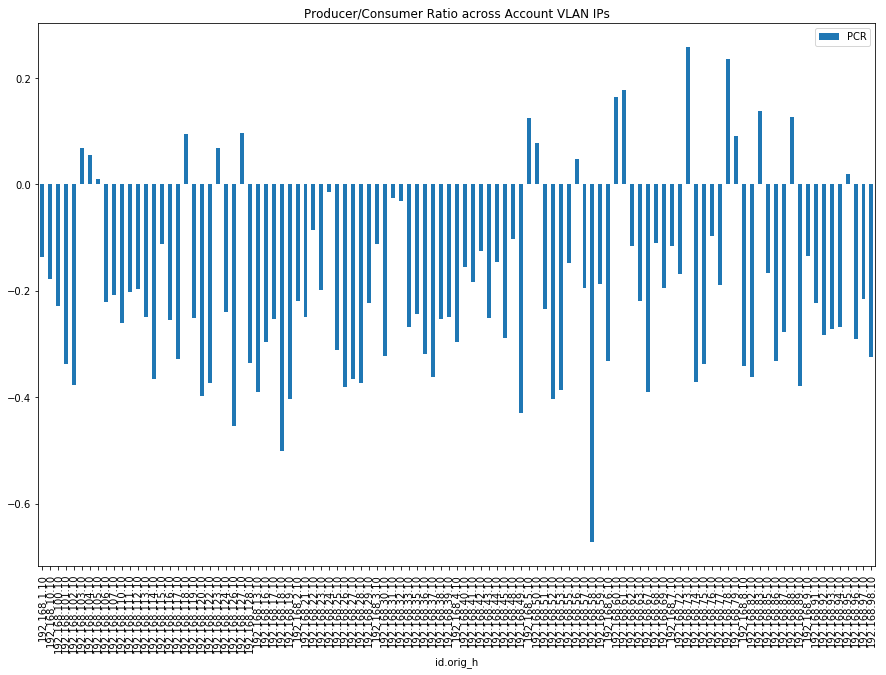

In [84]:
df.plot.bar(y='PCR', figsize=(15,10), title="Producer/Consumer Ratio across Account VLAN IPs")